In [75]:
import os
import warnings
import math
import weighted

import pandas as pd
import numpy as np
import statsmodels.api as sm

from tqdm import tqdm

from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
    get_derived_csv_path,
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [76]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)

In [77]:
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in os.listdir(trade_prices_data_path)
]

In [78]:
req_int_columns = ["Transaction-price(total)", "Area(m^2)"]

req_float_columns = ["Transaction-price(Unit price m^2)"]

req_object_columns = [
    "City,Town,Ward,Village code",
    "Type",
    "Region",
    # "Area", finer grain than Municipality
    "Use",
    "Purpose of Use",
    "Transaction period",
]

required_columns = req_int_columns + req_float_columns + req_object_columns

float_filler = dict((col, 0) for col in req_float_columns)
int_filler = dict((col, 0) for col in req_int_columns)
object_filler = dict((col, "na") for col in req_object_columns)
na_filler = {**float_filler, **int_filler, **object_filler}

In [79]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city["1101"]}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area["1100"]}") 

# In the future, we may want to use the 175 sub cities and just skip this
# Problem currently is that we don't have taxable income for sub cities
def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [80]:
def custom_aggregate(x):
    d = {}
    d["unit_price_wmean"] = np.average(x["unit_price"], weights=x["trade_area"])
    d["unit_price_wmedian"] = weighted.median(x["unit_price"], weights=x["trade_area"])
    d["unit_price_mean"] = x["unit_price"].mean()
    d["unit_price_median"] = x["unit_price"].median()
    d["total_traded_area"] = x["trade_area"].sum()
    d["count"] = x["count"].count()
    return pd.Series(
        d,
        index=[
            "unit_price_wmean",
            "unit_price_wmedian",
            "unit_price_mean",
            "unit_price_median",
            "total_traded_area",
            "count",
        ],
    )


def get_loess_parameters(
    area_code, area_to_diff_std, min_diff_std, max_diff_std, min_frac=0.3, max_frac=0.6
):
    diff_std = area_to_diff_std[area_code]
    diff_std = 1 if math.isnan(diff_std) else diff_std

    diff_score = (diff_std - min_diff_std) / (max_diff_std - min_diff_std)
    frac = min_frac + diff_score * (max_frac - min_frac)

    frac = min(frac, 0.8)
    frac = max(frac, 0.1)

    return (frac, 3, diff_score)


def filter_df(df, latest_year):
    return df[
        (df["year"] <= latest_year)
        & (df["Region"] != "Industrial Area")
        & (
            ~df["Use"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
        & (
            ~df["Purpose of Use"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
    ]

In [81]:
derived_dfs = {"land": pd.DataFrame(), "building": pd.DataFrame()}

pbar = tqdm(total=len(trade_prices_data_paths))

# TODO: spatial and temporal smoothing
for path in trade_prices_data_paths:
    main_df = pd.read_csv(path, usecols=required_columns, encoding="unicode_escape")
    main_df = main_df.assign(count=1)

    main_df["area_code"] = main_df["City,Town,Ward,Village code"].astype(str)

    # we may want to skip the following step in the future
    main_df["area_code"] = main_df["area_code"].apply(get_city_code).astype(str)
    main_df["area"] = main_df["area_code"].apply(get_area_from_area_code)

    main_df["trade_price"] = main_df["Transaction-price(total)"]
    main_df["trade_area"] = main_df["Area(m^2)"].apply(area_to_int)
    main_df["unit_price"] = main_df["Transaction-price(Unit price m^2)"]
    main_df["trade_price_per_area"] = main_df["trade_price"] / main_df["trade_area"]

    main_df["quarter"] = main_df["Transaction period"].apply(
        lambda x: int(x.split(" ")[0][0])
    )
    main_df["year"] = main_df["Transaction period"].apply(
        lambda x: int(x.split(" ")[2])
    )

    main_df["date"] = pd.PeriodIndex(
        year=main_df["year"], quarter=main_df["quarter"]
    ).to_timestamp()

    main_df["unit_price"] = np.where(
        main_df["unit_price"].isna(),
        main_df["trade_price_per_area"],
        main_df["unit_price"],
    )

    main_df = main_df.fillna(na_filler)

    for asset_type, asset_type_props in asset_types.items():
        df = main_df[main_df["Type"] == asset_type_props["label"]]

        # filter out unwanted transactions
        df = filter_df(df, 2022)

        # Aggregate
        df = (
            df.groupby(["year", "area_code", "area"])
            .apply(custom_aggregate)
            .reset_index()
        )
        df = df.sort_values(
            by=["year", "area_code"], ascending=[False, True]
        ).reset_index(drop=True)
        derived_dfs[asset_type] = pd.concat([derived_dfs[asset_type], df])

    pbar.update()
pbar.close()

  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [00:40<00:00,  1.15it/s]


In [82]:
# Temporal Smoothing

metrics = [
    "unit_price_wmean",
    "unit_price_wmedian",
    "unit_price_mean",
    "unit_price_median",
]

area_to_diff_std = {
    "land": {metric: {} for metric in metrics},
    "building": {metric: {} for metric in metrics},
}

area_to_loess_params = {
    "land": {metric: {} for metric in metrics},
    "building": {metric: {} for metric in metrics},
}

# Clean Data
for asset_type in asset_types:
    df = derived_dfs[asset_type]
    cleaned_df = pd.DataFrame()

    for area_code in df["area_code"].unique():
        area_df = df[df["area_code"] == area_code]
        area_df = area_df.sort_values(by="year", ascending=True)

        year_min = area_df["year"].min()
        year_max = area_df["year"].max()

        # Skip if area_df is non contiguous
        if year_max - year_min + 1 != len(area_df):
            continue

        # Remove first year and last year from each area that has count < 0.5 * avg_count. Loess can't handle weird tail values
        avg_count = area_df["count"].mean()

        if area_df["count"].iloc[0] < 0.5 * avg_count:
            area_df = area_df[area_df["year"] > year_min]

        if area_df["count"].iloc[-1] < 0.5 * avg_count:
            area_df = area_df[area_df["year"] < year_max]

        cleaned_df = pd.concat([cleaned_df, area_df])

    derived_dfs[asset_type] = cleaned_df

# Populate Area to Diff Std
for asset_type in asset_types:
    df = derived_dfs[asset_type]
    area_codes = df["area_code"].unique()

    for area_code in area_codes:
        area_df = df[df["area_code"] == area_code]
        area_df = area_df.sort_values(by="year", ascending=True)

        for metric in metrics:
            area_to_diff_std[asset_type][metric][area_code] = (
                area_df[metric].pct_change().std()
            )

# Populate LOESS Parameters
for asset_type in asset_types:
    df = derived_dfs[asset_type]
    area_codes = df["area_code"].unique()

    for metric in metrics:
        area_to_diff_std_series = pd.Series(area_to_diff_std[asset_type][metric])
        min_diff_std = area_to_diff_std_series.quantile(0.05)
        max_diff_std = area_to_diff_std_series.quantile(0.95)

        for area_code in area_codes:
            area_to_loess_params[asset_type][metric][area_code] = get_loess_parameters(
                area_code,
                area_to_diff_std[asset_type][metric],
                min_diff_std,
                max_diff_std,
            )


# Smooth Data
for asset_type in asset_types:
    df = derived_dfs[asset_type]
    smoothed_df = pd.DataFrame()

    for area_code in df["area_code"].unique():
        area_df = df[df["area_code"] == area_code]
        area_df = area_df.sort_values(by="year", ascending=True)

        # Smooth Data
        for metric in metrics:
            smoothed_metric = f"{metric}_smoothed"
            frac, it, _ = area_to_loess_params[asset_type][metric][area_code]
            area_df[smoothed_metric] = sm.nonparametric.lowess(
                area_df[metric], area_df.index, frac=frac, it=it, return_sorted=False
            )

        smoothed_df = pd.concat([smoothed_df, area_df])

    derived_dfs[asset_type] = smoothed_df

In [83]:
# Save derived dataframes
for asset_type, asset_type_props in asset_types.items():
    path = get_derived_csv_path(
        asset_type,
    )
    derived_dfs[asset_type].to_csv(
        path,
        index=False,
    )
    print(f"Wrote to {path}")

Wrote to ../../data/derived/transactions/land.csv
Wrote to ../../data/derived/transactions/building.csv


In [63]:
path = get_derived_csv_path(
    "building"
)
df = pd.read_csv(path)
df

,year,area_code,area,unit_price_wmean,unit_price_wmedian,unit_price_mean,unit_price_median,total_traded_area,count,unit_price_wmean_smoothed,unit_price_wmedian_smoothed,unit_price_mean_smoothed,unit_price_median_smoothed
0,2006,40100,Fukuoka-ken Kitakyushu-shi,123135.925350,91593.432007,119437.507441,92592.592593,112525.0,459.0,134347.049575,92578.624988,119437.507441,92226.296022
1,2007,40100,Fukuoka-ken Kitakyushu-shi,154605.377988,89655.172414,120627.727181,88461.538462,134065.0,501.0,136875.111908,88322.435411,120627.727181,89631.024375
2,2008,40100,Fukuoka-ken Kitakyushu-shi,144191.626651,84697.104858,131189.029457,88888.888889,133280.0,489.0,136846.081054,83702.718805,121817.946920,86698.057019
3,2009,40100,Fukuoka-ken Kitakyushu-shi,106914.891427,76146.997930,103221.781581,80000.000000,145755.0,560.0,116629.845465,79102.500006,111658.063384,86189.378953
4,2010,40100,Fukuoka-ken Kitakyushu-shi,102575.620512,77603.622431,107058.235796,87478.260870,176870.0,672.0,106671.193960,77238.455650,107058.203081,86209.353080
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21478,2017,29401,Nara-ken Takatori-cho,38497.652582,34048.600700,45804.910045,38980.509745,1065.0,4.0,38994.158767,33760.946580,42974.469523,38977.484382
21479,2018,29401,Nara-ken Takatori-cho,32307.692308,32307.692308,32307.692308,32307.692308,650.0,1.0,32227.873999,29931.903481,35202.626924,31927.703985
21480,2019,29401,Nara-ken Takatori-cho,22545.454545,22545.454545,22432.065217,22432.065217,275.0,2.0,29617.200961,24690.245588,34295.435309,27356.516508
21481,2020,29401,Nara-ken Takatori-cho,24390.243902,16462.053571,29329.004329,18506.493506,1025.0,4.0,27856.859149,22013.296779,34735.613850,23703.450612


In [64]:
# test_area = "1100" # Hokkaido Sapporo-shi
test_area = 28365 # Tokyo-to Chuo-ku

<Axes: xlabel='year'>

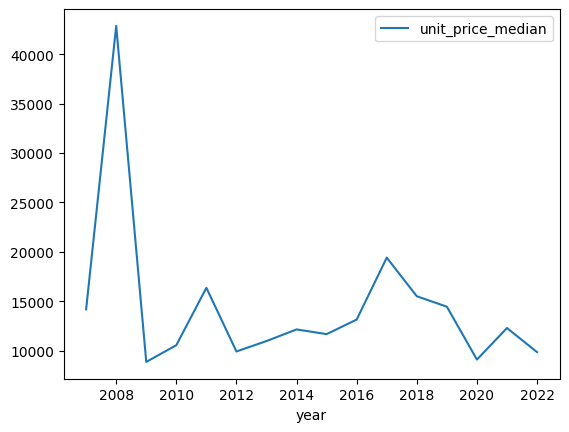

In [74]:
# median
df[df["area_code"] == test_area].plot(x="year", y="unit_price_median")

<Axes: xlabel='year'>

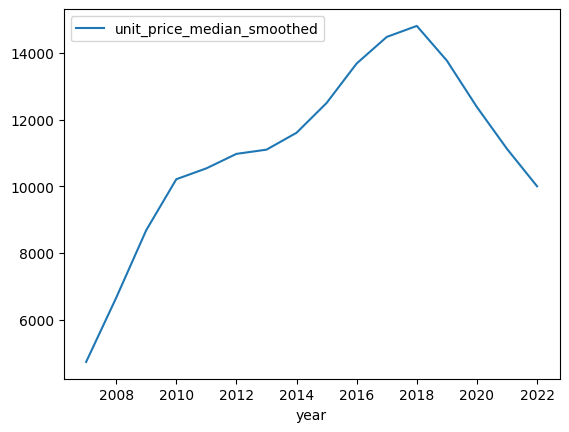

In [66]:
# median
df[df["area_code"] == test_area].plot(x="year", y="unit_price_median_smoothed")

<Axes: xlabel='year'>

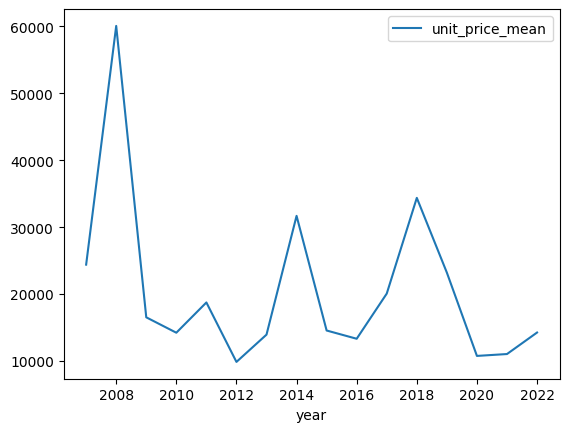

In [67]:
# mean
df[df["area_code"] == test_area].plot(x="year", y="unit_price_mean")

<Axes: xlabel='year'>

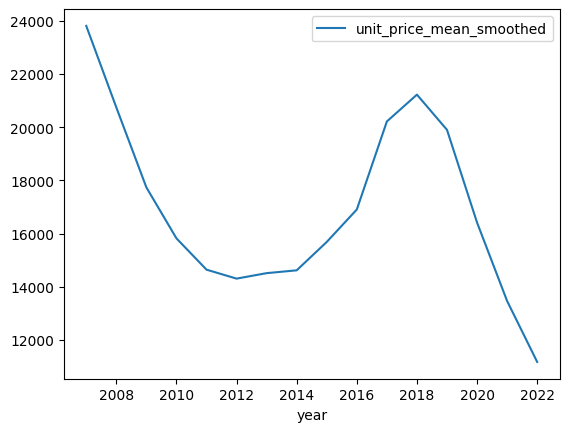

In [68]:
# mean
df[df["area_code"] == test_area].plot(x="year", y="unit_price_mean_smoothed")

<Axes: xlabel='year'>

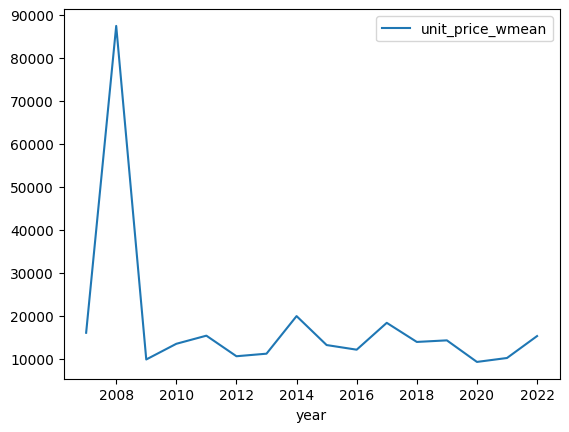

In [69]:
# weighted mean - this makes the most sense. Prices wouldn't be on the decline before the financial crisis
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmean")

<Axes: xlabel='year'>

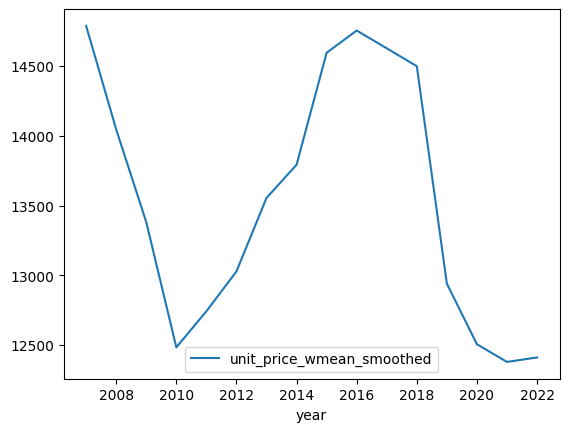

In [70]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmean_smoothed")

<Axes: xlabel='year'>

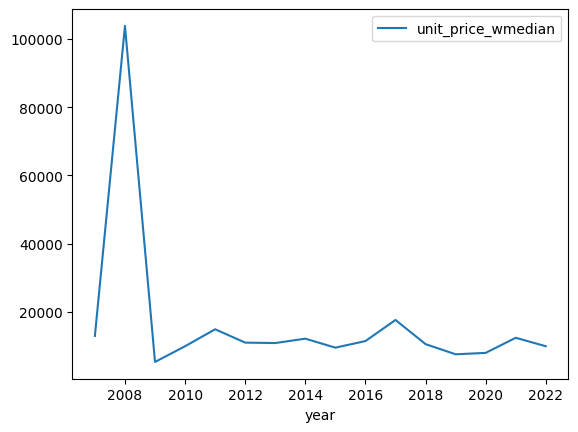

In [71]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmedian")

<Axes: xlabel='year'>

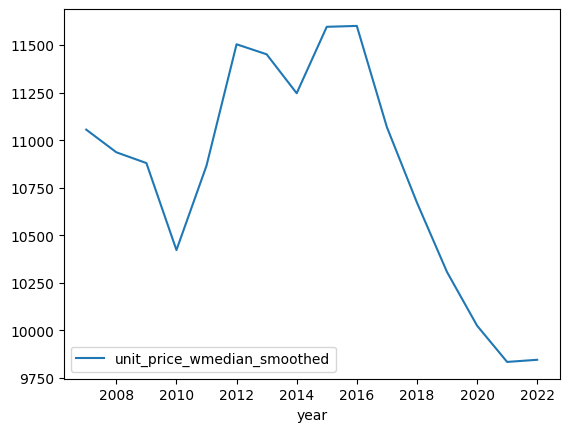

In [72]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmedian_smoothed")